This introduces another of the new features in the 2017.09 release of the RDKit: the `SubstructLibrary` - a class to make it straightforward to do substructure searches across sets of compounds.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import time
print(rdBase.rdkitVersion)
print(time.asctime())

2018.03.1.dev1
Thu Feb 22 06:47:45 2018


In [2]:
from rdkit.Chem import rdSubstructLibrary

To improve the efficiency of searches, the `SubstructLibary` allows you to provide RDKit Pattern fingerprints for the compounds in the library. These can (and should) be precalculated. Here's one way to do so.

The dataset here is the set of ~180K molecules in ChEMBL23 that have a measured activity of less than 100nM in any assay. If you're interested, the query I used to construct that set from my local ChEMBL install was:

```select chembl_id,m rdk_smiles from rdk.mols 
 join (select distinct(molregno) from activities where standard_units='nM' and standard_value<10) tmp 
   using (molregno) 
 join (select chembl_id,entity_id molregno from chembl_id_lookup where entity_type='COMPOUND') tmp2 
   using (molregno);```

Build our first `SubstructLibrary`. There are a number of ways of doing this, here we'll build one that expects that the molecules are provided as "trusted" SMILES (i.e. SMILES where the aromaticity and stereochemistry has been set by the RDKit). We'll add the SMILES (without actually converting them into molecule) and the fingerprints we calculated above

In [3]:
import pickle, time
t1=time.time()
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.PatternHolder()
with open('../data/chembl23_very_active.txt','r') as inf:
    ls = [x.split() for x in inf]
    ls.pop(0)
    with open('../data/chembl23_very_active.fps.pkl','rb') as pklf:
        for l in ls:
            smi = l[1]
            mols.AddSmiles(smi)           
            fp = pickle.load(pklf)
            fps.AddFingerprint(fp)
library = rdSubstructLibrary.SubstructLibrary(mols,fps)
t2=time.time()
print("That took %.2f seconds. The library has %d molecules."%(t2-t1,len(library)))

That took 3.82 seconds. The library has 184383 molecules.


In [4]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ccncn1'))
print(len(indices))

1000


In [5]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ccncn1'),maxResults=50000)
print(len(indices))

28087


In [6]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ncncn1'))
print(len(indices))

907


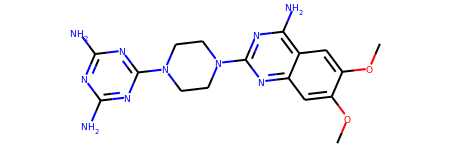

In [7]:
library.GetMol(indices[0])

Let's look at how long that takes:

In [8]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ncncn1'))

28 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Another example with a somewhat larger query:

808


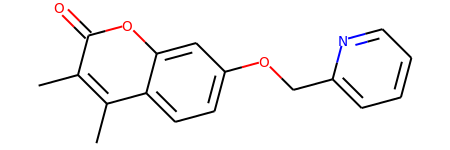

In [9]:
indices = library.GetMatches(Chem.MolFromSmiles('O=C1OC2=C(C=CC=C2)C=C1'),maxResults=10000)
print(len(indices))
library.GetMol(indices[0])

In [10]:
%timeit library.GetMatches(Chem.MolFromSmiles('O=C1OC2=C(C=CC=C2)C=C1'),maxResults=10000)

14.2 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So far so good: we've got fast searches across the ~180K molecules in that dataset. Let's look at a larger dataset.

Here's the pre-processing work for 500K molecules randomly selected from ChEMBL:

The same code as above to read them in:

In [11]:
import pickle,time
t1=time.time()
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.PatternHolder()
with open('../data/chembl_500K.txt','r') as inf:
    ls = [x.split() for x in inf]
    ls.pop(0)
    with open('../data/chembl_500K.fps.pkl','rb') as pklf:
        for l in ls:
            smi = l[1]
            try:
                fp = pickle.load(pklf)
            except EOFError:
                break
            mols.AddSmiles(smi)           
            fps.AddFingerprint(fp)
library = rdSubstructLibrary.SubstructLibrary(mols,fps)
t2=time.time()
print("That took %.2f seconds. The library has %d molecules."%(t2-t1,len(library)))

That took 9.31 seconds. The library has 500000 molecules.


Now let's do some searches

373


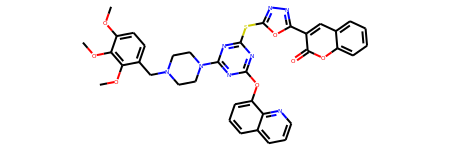

In [12]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ncnc(O)n1'))
print(len(indices))
library.GetMol(indices[0])

In [13]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ncnc(O)n1'))

51.4 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


3520


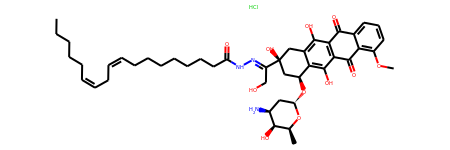

In [14]:
indices = library.GetMatches(Chem.MolFromSmiles('c1ccccc1C(=O)c1ccccc1'),maxResults=10000)
print(len(indices))
library.GetMol(indices[0])

In [15]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ccccc1C(=O)c1ccccc1'),maxResults=10000)

695 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


One of the reasons this is so fast is that by default the search uses multiple threads to run in parallel. You can see the impact of reducing the number of threads to one:

In [16]:
%timeit library.GetMatches(Chem.MolFromSmiles('c1ccccc1C(=O)c1ccccc1'),maxResults=10000, numThreads=1)

2.63 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's it for this post. I hope you find the `SubstructLibrary` useful!